# **ライブラリの準備**

In [122]:
!pip install japanize_matplotlib
!pip install catboost
!pip install jpholiday
!pip install optuna

In [123]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import jpholiday


from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

データのあるディレクトリまで移動する

In [124]:
%cd /content/drive/MyDrive/ml_practice/soccer

/content/drive/MyDrive/ml_practice/soccer


# **データの準備**

In [125]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_add = pd.read_csv('train_add.csv')
add_2014 = pd.read_csv('2014_add.csv')
stadium = pd.read_csv('stadium.csv')
condition = pd.read_csv('condition.csv')
condition_add = pd.read_csv('condition_add.csv')

各データのサイズの確認

In [126]:
print('train shape: ', train.shape)
print('train_add shape: ', train_add.shape)
print('test shape: ',test.shape)
print('condition shape: ', condition.shape)
print('condition_add shape: ', condition_add.shape)
print('stadium shape:', stadium.shape)

train shape:  (1721, 11)
train_add shape:  (232, 11)
test shape:  (313, 10)
condition shape:  (2034, 31)
condition_add shape:  (270, 31)
stadium shape: (59, 3)


trainデータの確認

In [127]:
display(train.head(), train_add.head())

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌


,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,14003,19010,2012,Ｊ１,第２節第１日,03/17(土),14:04,鹿島アントラーズ,川崎フロンターレ,県立カシマサッカースタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ水戸
1,14020,15072,2012,Ｊ１,第３節第２日,03/25(日),19:03,ガンバ大阪,ジュビロ磐田,万博記念競技場,スカパー／ｅ２／スカパー光
2,14023,25743,2012,Ｊ１,第４節第１日,03/31(土),15:03,浦和レッズ,川崎フロンターレ,埼玉スタジアム２００２,スカパー／ｅ２／スカパー光／テレ玉
3,14076,24183,2012,Ｊ１,第１０節第１日,05/06(日),13:03,横浜Ｆ・マリノス,コンサドーレ札幌,日産スタジアム,スカパー／ｅ２／スカパー光
4,14081,20512,2012,Ｊ１,第１０節第１日,05/06(日),17:03,名古屋グランパス,川崎フロンターレ,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／名古屋テレビ（録）


conditionデータの確認

In [128]:
display(condition.head(), condition_add.head())

,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ
1,13995,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,...,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀
2,13996,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人
3,13997,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,...,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也
4,13998,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,...,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一


,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,14003,0,1,雨,13.3,86%,西村 雄一,鹿島アントラーズ,曽ヶ端 準,新井場 徹,...,實藤 友紀,ジェシ,森下 俊,小宮山 尊信,中村 憲剛,柴崎 晃誠,田坂 祐介,山瀬 功治,レナト,小松 塁
1,14020,1,2,曇,4.6,56%,家本 政明,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,駒野 友一,チョ ビョングク,藤田 義明,金沢 浄,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一
2,14023,1,1,雨,10.0,65%,家本 政明,浦和レッズ,加藤 順大,坪井 慶介,...,田中 裕介,ジェシ,森下 俊,小宮山 尊信,中村 憲剛,柴崎 晃誠,田坂 祐介,山瀬 功治,レナト,小松 塁
3,14076,2,1,晴,27.9,47%,今村 義朗,横浜Ｆ・マリノス,飯倉 大樹,小林 祐三,...,日高 拓磨,ジェイド ノース,櫛引 一紀,岩沼 俊介,河合 竜二,宮澤 裕樹,古田 寛幸,近藤 祐介,高木 純平,前田 俊介
4,14081,2,3,晴,19.0,48%,吉田 寿光,名古屋グランパス,楢﨑 正剛,石櫃 洋祐,...,田中 裕介,井川 祐輔,森下 俊,登里 享平,稲本 潤一,中村 憲剛,大島 僚太,田坂 祐介,楠神 順平,矢島 卓郎


stadiumデータの確認

In [129]:
stadium.head()

,name,address,capa
0,名古屋市瑞穂陸上競技場,愛知県名古屋市瑞穂区山下通5-1,20000
1,豊田スタジアム,愛知県豊田市千石町7-2,40000
2,フクダ電子アリーナ,千葉県千葉市中央区川崎町1-20,18500
3,日立柏サッカー場,千葉県柏市日立台1-2-50,15349
4,ニンジニアスタジアム,愛媛県松山市上野町乙46,15576


testデータの確認

In [130]:
test.head()

,id,year,stage,match,gameday,time,home,away,stadium,tv
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス
1,15823,2014,Ｊ１,第１８節第１日,08/02(土),18:34,鹿島アントラーズ,サンフレッチェ広島,県立カシマサッカースタジアム,スカパー！／スカパー！プレミアムサービス
2,15824,2014,Ｊ１,第１８節第１日,08/02(土),19:04,浦和レッズ,ヴィッセル神戸,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉
3,15825,2014,Ｊ１,第１８節第１日,08/02(土),19:03,柏レイソル,川崎フロンターレ,日立柏サッカー場,スカパー！／スカパー！プレミアムサービス
4,15827,2014,Ｊ１,第１８節第１日,08/02(土),19:03,アルビレックス新潟,セレッソ大阪,デンカビッグスワンスタジアム,スカパー！／スカパー！プレミアムサービス


# **データの前処理**

データの結合

In [131]:
full_train = pd.concat([train, train_add], axis=0)
full_condition = pd.concat([condition, condition_add], axis=0)

stadium = stadium.rename(columns={'name': 'stadium'})
stadium = stadium[['stadium', 'capa']]
full_condition = full_condition[['id' ,'weather' ,'temperature' ,'humidity', 'home_score', 'away_score', 'home_team', 'away_team']]

full_train = pd.merge(full_train, stadium, on='stadium',  how='left')
full_train = pd.merge(full_train, full_condition, on='id',  how='left')
full_test = pd.merge(test, stadium, on='stadium',  how='left')
full_test = pd.merge(full_test, full_condition, on='id',  how='left')

full_train, full_testの確認

In [132]:
display(full_train.head(), full_test.head())
print('full_train shape: ', full_train.shape)
print('full_test shape: ', full_test.shape)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity,home_score,away_score,home_team,away_team
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,19694,雨,3.8,66%,1,0,ベガルタ仙台,鹿島アントラーズ
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,40000,屋内,12.4,43%,1,0,名古屋グランパス,清水エスパルス
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,21000,晴一時雨,11.3,41%,2,3,ガンバ大阪,ヴィッセル神戸
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島,50000,曇一時雨のち晴,11.4,52%,1,0,サンフレッチェ広島,浦和レッズ
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌,39232,屋内,22.5,32%,0,0,コンサドーレ札幌,ジュビロ磐田


,id,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity,home_score,away_score,home_team,away_team
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,19694,晴,27.4,70%,2,2,ベガルタ仙台,大宮アルディージャ
1,15823,2014,Ｊ１,第１８節第１日,08/02(土),18:34,鹿島アントラーズ,サンフレッチェ広島,県立カシマサッカースタジアム,スカパー！／スカパー！プレミアムサービス,40728,晴,30.8,65%,5,1,鹿島アントラーズ,サンフレッチェ広島
2,15824,2014,Ｊ１,第１８節第１日,08/02(土),19:04,浦和レッズ,ヴィッセル神戸,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉,63700,晴,31.7,58%,2,2,浦和レッズ,ヴィッセル神戸
3,15825,2014,Ｊ１,第１８節第１日,08/02(土),19:03,柏レイソル,川崎フロンターレ,日立柏サッカー場,スカパー！／スカパー！プレミアムサービス,15349,晴,29.3,76%,4,1,柏レイソル,川崎フロンターレ
4,15827,2014,Ｊ１,第１８節第１日,08/02(土),19:03,アルビレックス新潟,セレッソ大阪,デンカビッグスワンスタジアム,スカパー！／スカパー！プレミアムサービス,42300,晴,30.4,68%,1,0,アルビレックス新潟,セレッソ大阪


full_train shape:  (1953, 19)
full_test shape:  (313, 18)


データ構造の確認

In [133]:
display(full_train.info(), full_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1953 non-null   int64  
 1   y            1953 non-null   int64  
 2   year         1953 non-null   int64  
 3   stage        1953 non-null   object 
 4   match        1953 non-null   object 
 5   gameday      1953 non-null   object 
 6   time         1953 non-null   object 
 7   home         1953 non-null   object 
 8   away         1953 non-null   object 
 9   stadium      1953 non-null   object 
 10  tv           1953 non-null   object 
 11  capa         1953 non-null   int64  
 12  weather      1953 non-null   object 
 13  temperature  1953 non-null   float64
 14  humidity     1953 non-null   object 
 15  home_score   1953 non-null   int64  
 16  away_score   1953 non-null   int64  
 17  home_team    1953 non-null   object 
 18  away_team    1953 non-null   object 
dtypes: flo

None

None

カテゴリ変数の加工

In [134]:
full_train['section'] = full_train['match'].apply(lambda x: x.split('節')[0][1:]).astype(int)
full_test['section'] = full_test['match'].apply(lambda x: x.split('節')[0][1:]).astype(int)

full_train['month'] = full_train['gameday'].apply(lambda x: x[:2]).astype(int)
full_train['weekday'] = full_train['gameday'].apply(lambda x: x[6])
full_test['month'] = full_test['gameday'].apply(lambda x: x[:2]).astype(int)
full_test['weekday'] = full_test['gameday'].apply(lambda x: x[6])

weekday_mapping = {
    '月': 0,
    '火': 1,
    '水': 2,
    '木': 3,
    '金': 4,
    '土': 5,
    '日': 6
}
full_train['weekday'] = full_train['weekday'].map(weekday_mapping)
full_test['weekday'] = full_test['weekday'].map(weekday_mapping)

full_train['hour'] = full_train['time'].apply(lambda x: x.split(':')[0]).astype(int)
full_test['hour'] = full_test['time'].apply(lambda x: x.split(':')[0]).astype(int)

full_train['tv_num'] = full_train['tv'].apply(lambda x: len(x.split('／')))
full_test['tv_num'] = full_test['tv'].apply(lambda x: len(x.split('／')))

full_train['humidity'] = full_train['humidity'].apply(lambda x: x.rstrip('%')).astype(int)
full_test['humidity'] = full_test['humidity'].apply(lambda x: x.rstrip('%')).astype(int)

full_train, full_testの統計値の確認

In [135]:
display(full_train.describe(), full_test.describe())

,id,y,year,capa,temperature,humidity,home_score,away_score,section,month,weekday,hour,tv_num
count,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000
mean,15049.442396,10629.558116,2012.820276,25688.549411,20.438914,60.220174,1.366103,1.204301,18.050691,6.316948,4.923707,16.310804,2.656938
std,646.260483,8102.315189,0.758124,14016.934408,6.438737,19.953138,1.203060,1.125224,11.153364,2.500493,1.480687,2.310252,0.715085
min,13994.000000,0.000000,2012.000000,3560.000000,1.400000,12.000000,0.000000,0.000000,1.000000,3.000000,0.000000,12.000000,1.000000
25%,14482.000000,4687.000000,2012.000000,15589.000000,15.800000,44.000000,0.000000,0.000000,9.000000,4.000000,5.000000,14.000000,2.000000
50%,15044.000000,8594.000000,2013.000000,20246.000000,21.400000,63.000000,1.000000,1.000000,17.000000,6.000000,5.000000,16.000000,3.000000
75%,15532.000000,13471.000000,2013.000000,30132.000000,25.600000,77.000000,2.000000,2.000000,27.000000,8.000000,6.000000,19.000000,3.000000
max,16238.000000,62632.000000,2014.000000,72327.000000,34.200000,99.000000,7.000000,8.000000,42.000000,12.000000,6.000000,20.000000,5.000000


,id,year,capa,temperature,humidity,home_score,away_score,section,month,weekday,hour,tv_num
count,313.000000,313.0,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,16142.252396,2014.0,26493.354633,21.666773,64.894569,1.434505,1.169329,30.162939,9.418530,5.070288,16.664537,2.380192
std,224.441223,0.0,14237.841998,5.073073,17.748557,1.166997,1.106545,6.249792,1.179652,1.303906,2.300903,0.609111
min,15822.000000,2014.0,7258.000000,1.300000,19.000000,0.000000,0.000000,18.000000,8.000000,0.000000,12.000000,2.000000
25%,15907.000000,2014.0,15600.000000,19.000000,51.000000,1.000000,0.000000,26.000000,8.000000,5.000000,14.000000,2.000000
50%,16261.000000,2014.0,20396.000000,22.600000,66.000000,1.000000,1.000000,30.000000,9.000000,5.000000,18.000000,2.000000
75%,16346.000000,2014.0,32000.000000,25.200000,79.000000,2.000000,2.000000,34.000000,10.000000,6.000000,19.000000,3.000000
max,16436.000000,2014.0,72327.000000,31.700000,99.000000,5.000000,5.000000,42.000000,12.000000,6.000000,19.000000,5.000000


観客動員数が0の試合を確認

In [136]:
full_train[full_train['y']==0]

,id,y,year,stage,match,gameday,time,home,away,stadium,...,humidity,home_score,away_score,home_team,away_team,section,month,weekday,hour,tv_num
1385,15699,0,2014,Ｊ１,第４節第１日,03/23(日),15:04,浦和レッズ,清水エスパルス,埼玉スタジアム２００２,...,23,1,1,浦和レッズ,清水エスパルス,4,3,6,15,3


例外で無観客試合になっていたため今回は外れ値として扱い、除去する

In [137]:
full_train.drop(index=1385, inplace=True)
full_train[full_train['y']==0]

,id,y,year,stage,match,gameday,time,home,away,stadium,...,humidity,home_score,away_score,home_team,away_team,section,month,weekday,hour,tv_num


# **データの可視化**

sectionごとの観客動員数の分布

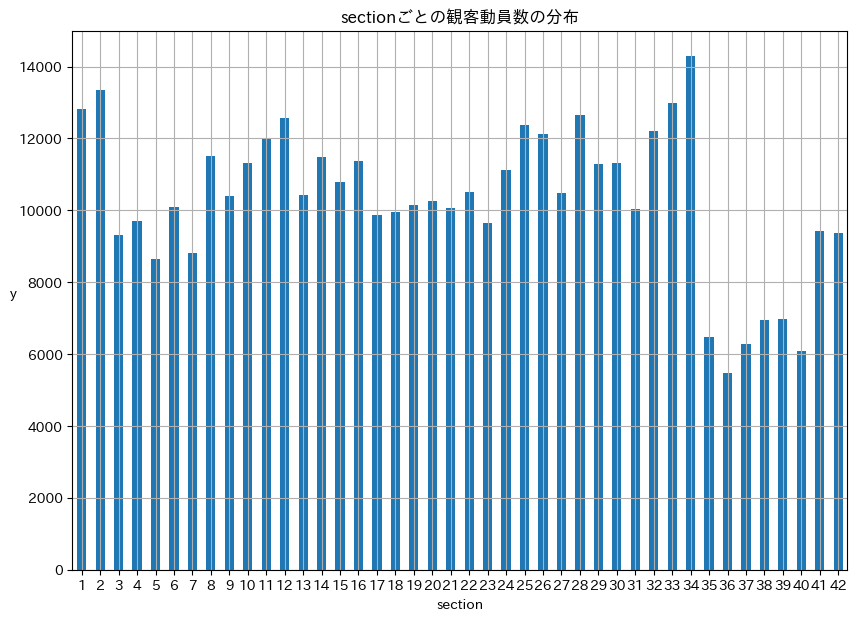

In [138]:
plt.figure(figsize=(10, 7))
full_train.groupby('section')['y'].mean().plot.bar()
plt.grid()
plt.xlabel('section')
plt.xticks(rotation=0)
plt.ylabel('y', rotation=0)
plt.title('sectionごとの観客動員数の分布')
plt.show()

J1とJ2それぞれの\観客動員数の平均

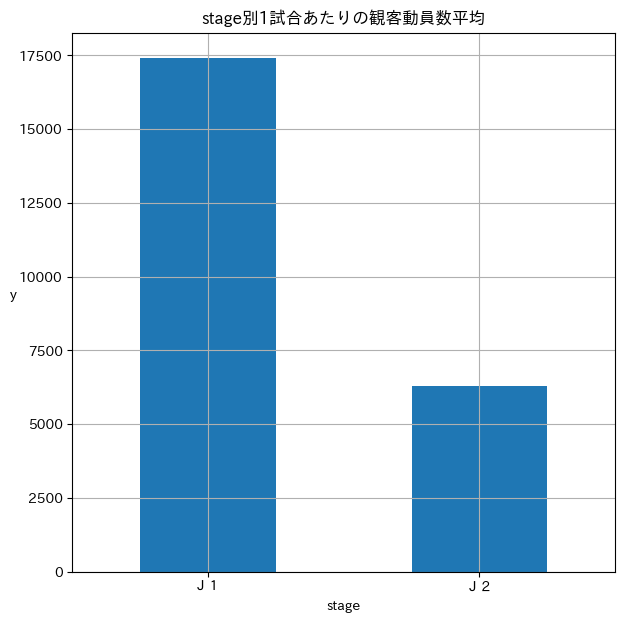

In [139]:
plt.figure(figsize=(7, 7))
full_train.groupby('stage')['y'].mean().plot.bar()
plt.grid()
plt.xticks(rotation=0)
plt.ylabel('y', rotation=0)
plt.title('stage別1試合あたりの観客動員数平均')
plt.show()

stage別のsectionごとの観客動員数の分布

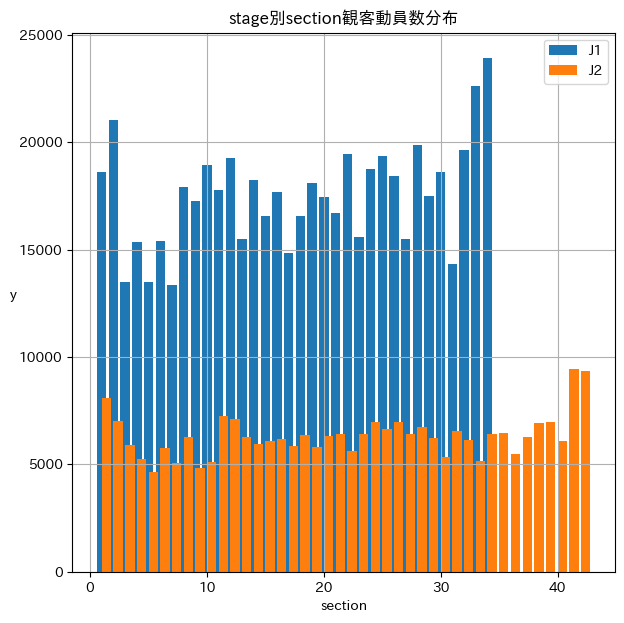

In [140]:
plt.figure(figsize=(7, 7))
J1_group = full_train[full_train['stage'] == 'Ｊ１'].groupby('section')['y'].mean()
J2_group = full_train[full_train['stage'] == 'Ｊ２'].groupby('section')['y'].mean()
plt.bar(J1_group.index, J1_group, label='J1')
plt.bar(J2_group.index, J2_group, label='J2', align='edge')
plt.legend()
plt.grid()
plt.xlabel('section')
plt.ylabel('y', rotation=0)
plt.title('stage別section観客動員数分布')
plt.show()

homeチームごとの観客動員数の分布

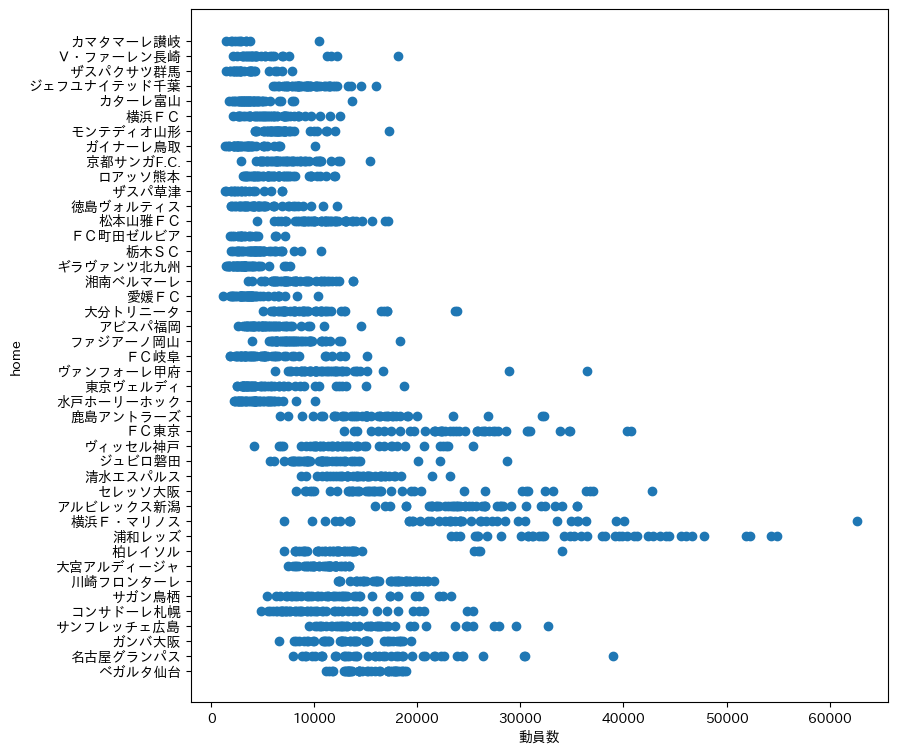

In [141]:
plt.figure(figsize=(9,9))
plt.scatter(full_train['y'], full_train['home'])
plt.xlabel('動員数')
plt.ylabel('home')
plt.show()

awayチームごとの観客動員数の分布

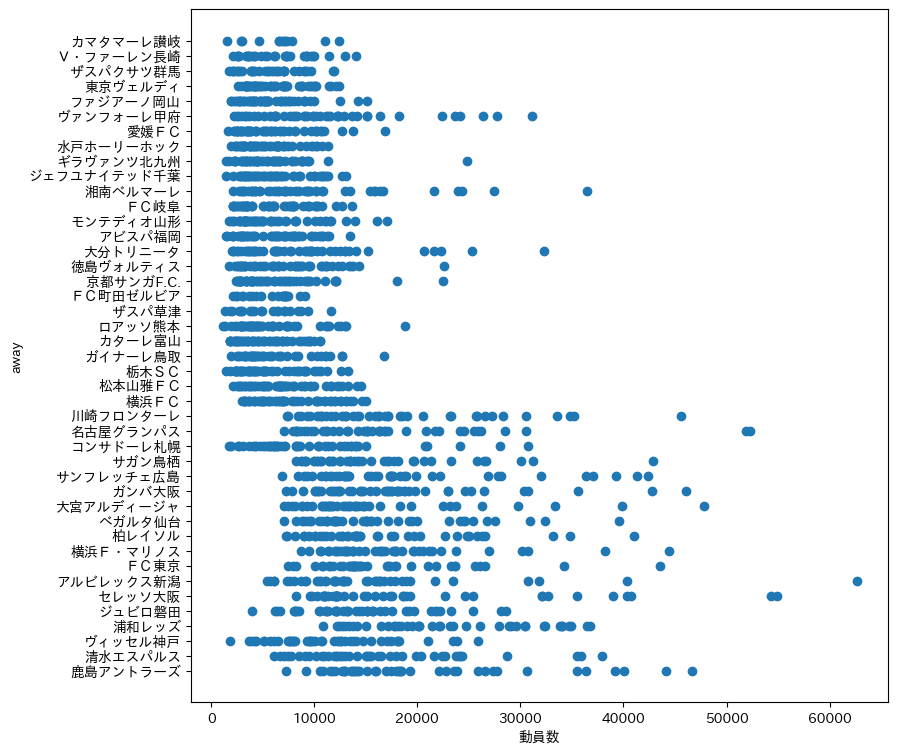

In [142]:
plt.figure(figsize=(9,9))
plt.scatter(full_train['y'], full_train['away'])
plt.xlabel('動員数')
plt.ylabel('away')
plt.show()

曜日ごとの観客動員数の分布

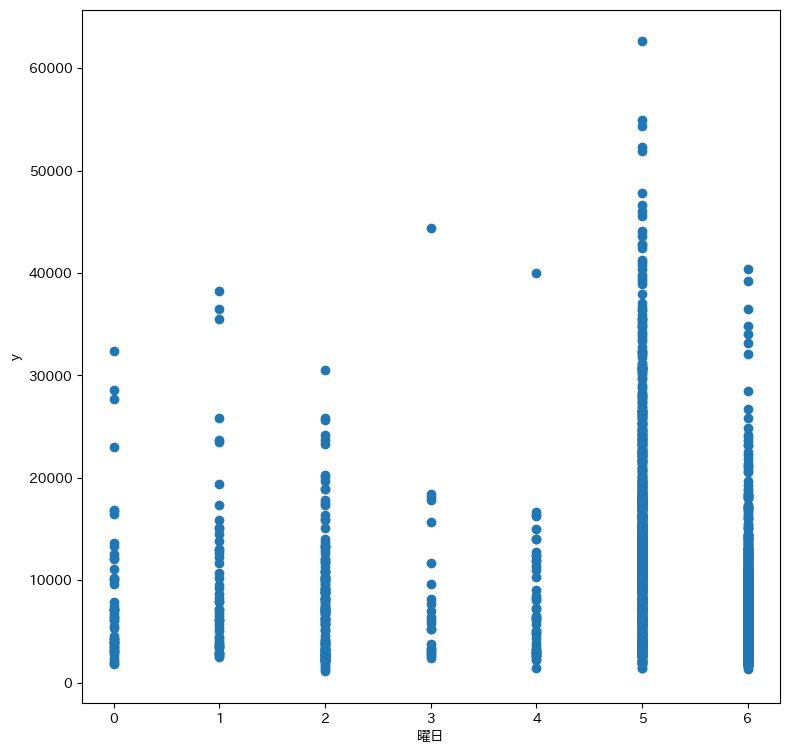

In [143]:
plt.figure(figsize=(9,9))
plt.scatter(full_train['weekday'], full_train['y'])
plt.xlabel('曜日')
plt.ylabel('y')
plt.show()

capaごとの観客動員数の分布

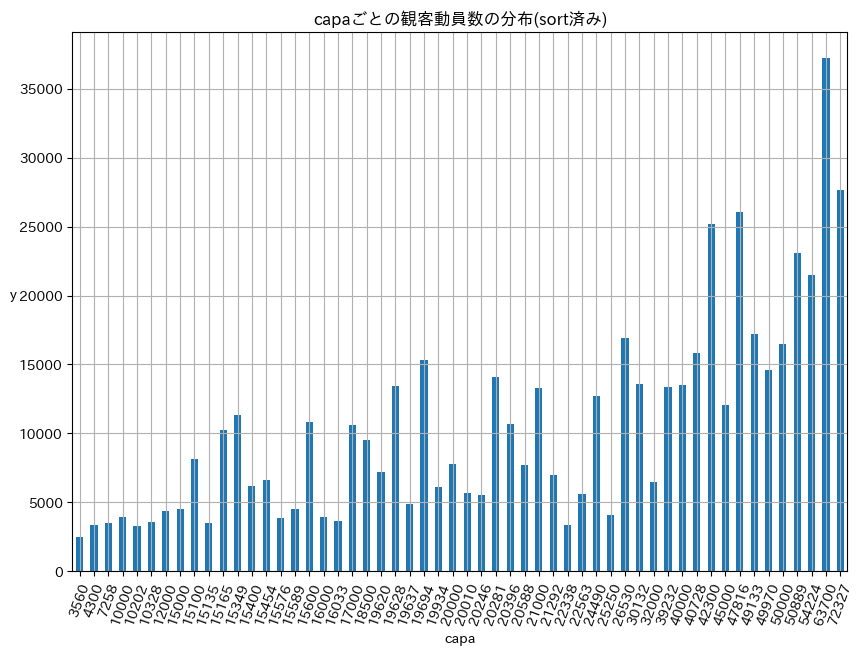

In [144]:
capa_mean = full_train.groupby('capa')['y'].mean().sort_index()

plt.figure(figsize=(10, 7))
capa_mean.plot.bar()
plt.grid()
plt.xlabel('capa')
plt.xticks(rotation=70)
plt.ylabel('y', rotation=0)
plt.title('capaごとの観客動員数の分布(sort済み)')
plt.show()

capaのヒストグラム

(array([ 84., 546., 662., 179.,  48., 189., 150.,  18.,  42.,  34.]),
 array([ 3560. , 10436.7, 17313.4, 24190.1, 31066.8, 37943.5, 44820.2,
        51696.9, 58573.6, 65450.3, 72327. ]),
 <BarContainer object of 10 artists>)

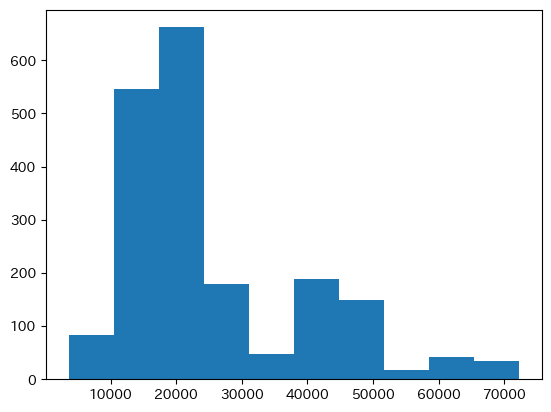

In [145]:
plt.hist(full_train['capa'])

観客動員数の多いゲームと少ないゲームを30000人をしきい値として区別

それぞれの統計値の確認

In [146]:
top_game = full_train[full_train['y'] >= 30000]
bot_game = full_train[full_train['y'] <= 30000]

display(top_game.describe(), bot_game.describe())

,id,y,year,capa,temperature,humidity,home_score,away_score,section,month,weekday,hour,tv_num
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,14878.200000,37294.933333,2012.853333,57484.786667,20.801333,59.840000,1.440000,1.253333,19.200000,7.360000,4.786667,16.706667,2.866667
std,601.341271,6750.664416,0.747850,10179.161795,6.866635,19.777847,1.275973,1.356599,9.593072,2.689519,1.106410,1.978078,0.890389
min,14004.000000,30047.000000,2012.000000,40000.000000,5.000000,22.000000,0.000000,0.000000,1.000000,3.000000,0.000000,13.000000,2.000000
25%,14224.500000,32202.000000,2012.000000,47816.000000,16.500000,43.500000,1.000000,0.000000,11.000000,5.000000,5.000000,15.000000,2.000000
50%,15017.000000,35528.000000,2013.000000,63700.000000,21.600000,65.000000,1.000000,1.000000,20.000000,8.000000,5.000000,17.000000,3.000000
75%,15128.000000,40371.500000,2013.000000,63700.000000,27.400000,74.000000,2.000000,2.000000,27.000000,9.500000,5.000000,19.000000,3.000000
max,15813.000000,62632.000000,2014.000000,72327.000000,31.000000,93.000000,6.000000,6.000000,34.000000,12.000000,6.000000,19.000000,5.000000


,id,y,year,capa,temperature,humidity,home_score,away_score,section,month,weekday,hour,tv_num
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,15055.938732,9569.742674,2012.818327,24397.803942,20.426692,60.255194,1.363346,1.202451,18.012254,6.277038,4.928609,16.295685,2.648375
std,647.200888,6074.442049,0.758410,12549.550873,6.423549,19.951978,1.200612,1.115664,11.209260,2.483843,1.493846,2.322011,0.706325
min,13994.000000,1104.000000,2012.000000,3560.000000,1.400000,12.000000,0.000000,0.000000,1.000000,3.000000,0.000000,12.000000,1.000000
25%,14490.000000,4509.000000,2012.000000,15589.000000,15.800000,44.000000,0.000000,0.000000,9.000000,4.000000,5.000000,14.000000,2.000000
50%,15047.000000,8197.000000,2013.000000,20000.000000,21.400000,63.000000,1.000000,1.000000,17.000000,6.000000,5.000000,16.000000,3.000000
75%,15534.000000,12896.000000,2013.000000,26530.000000,25.500000,77.000000,2.000000,2.000000,27.000000,8.000000,6.000000,19.000000,3.000000
max,16238.000000,29722.000000,2014.000000,72327.000000,34.200000,99.000000,7.000000,8.000000,42.000000,12.000000,6.000000,20.000000,5.000000


正規分布の確認

(array([835., 621., 274., 105.,  58.,  32.,  17.,   5.,   4.,   1.]),
 array([ 1104. ,  7256.8, 13409.6, 19562.4, 25715.2, 31868. , 38020.8,
        44173.6, 50326.4, 56479.2, 62632. ]),
 <BarContainer object of 10 artists>)

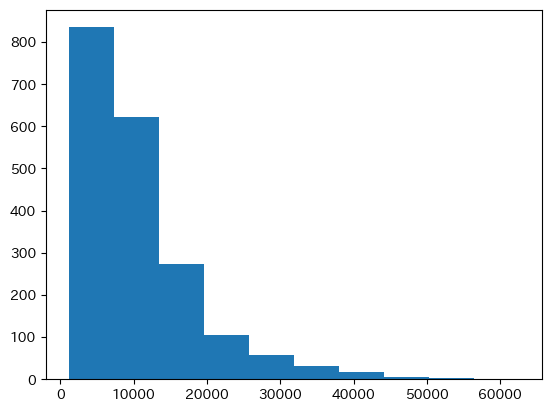

In [147]:
plt.hist(full_train['y'])

左に寄っているため後で対数変換を行う

# **特徴量の作成**

休日、祝日フラグの作成

In [148]:
full_train['is_offday'] = np.where(full_train['weekday'] >= 5, 1, 0)
full_test['is_offday'] = np.where(full_test['weekday'] >= 5, 1, 0)

full_train["date"] = pd.to_datetime(full_train["year"].astype(str) + "/" + full_train["gameday"].str[:5])
full_test["date"] = pd.to_datetime(full_test["year"].astype(str) + "/" + full_test["gameday"].str[:5])
full_train['is_holiday'] = full_train['date'].apply(lambda x: 1 if jpholiday.is_holiday(x) else 0)
full_test['is_holiday'] = full_test['date'].apply(lambda x: 1 if jpholiday.is_holiday(x) else 0)

full_train['offday'] = full_train['is_offday'] + full_train['is_holiday']
full_test['offday'] = full_test['is_offday'] + full_test['is_holiday']

homeのターゲットエンコーディング

In [149]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
te_train = pd.Series(index=full_train.index, dtype=float)

for train_idx, val_idx in kf.split(full_train):
    fold_train = full_train.iloc[train_idx]
    mean_map = fold_train.groupby('home')['y'].mean()
    te_train.iloc[val_idx] = full_train.iloc[val_idx]['home'].map(mean_map)

te_train.fillna(full_train['y'].mean(), inplace=True)
full_train['home_te'] = te_train

mean_map = full_train.groupby('home')['y'].mean()

full_test['home_te'] = full_test['home'].map(mean_map)

full_test['home_te'].fillna(full_train['y'].mean(), inplace=True)

awayのターゲットエンコーディング

In [150]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
te_train = pd.Series(index=full_train.index, dtype=float)

for train_idx, val_idx in kf.split(full_train):
    fold_train = full_train.iloc[train_idx]
    mean_map = fold_train.groupby('away')['y'].mean()
    te_train.iloc[val_idx] = full_train.iloc[val_idx]['away'].map(mean_map)

te_train.fillna(full_train['y'].mean(), inplace=True)
full_train['away_te'] = te_train

mean_map = full_train.groupby('away')['y'].mean()

full_test['away_te'] = full_test['away'].map(mean_map)

full_test['away_te'].fillna(full_train['y'].mean(), inplace=True)

ラグ変数の作成（三個前の試合までを使用）

In [151]:
for lag in [1,2,3]:
    full_train[f'lag_{lag}'] = full_train['y'].shift(lag)

test_lag_values = full_train['y'].iloc[-3:].values

full_test['lag_1'] = test_lag_values[2]
full_test['lag_2'] = test_lag_values[1]
full_test['lag_3'] = test_lag_values[0]

チームの人気度を定量化（得点率 × capa × stage）

In [152]:
full_train['stage_num'] = full_train['stage'].map({'Ｊ１': 2, 'Ｊ２': 1})
full_test['stage_num'] = full_test['stage'].map({'Ｊ１': 2, 'Ｊ２': 1})

full_train['popular'] = full_train['home_score'] * full_train['capa'] * full_train['stage_num']
full_test['popular'] = full_test['home_score'] * full_test['capa'] * full_test['stage_num']

full_train['popular'] = np.log1p(full_train['popular'])
full_test['popular'] = np.log1p(full_test['popular'])

前年のチームの得点率

In [153]:
scores = pd.concat([
    full_train.groupby(['home','year'])['home_score'].sum().reset_index().rename(columns={'home':'team','home_score':'goals'}),
    full_train.groupby(['away','year'])['away_score'].sum().reset_index().rename(columns={'away':'team','away_score':'goals'})
]).groupby(['team','year'])['goals'].sum().reset_index()

games = pd.concat([
    full_train.groupby(['home','year']).size().reset_index(name='games').rename(columns={'home':'team'}),
    full_train.groupby(['away','year']).size().reset_index(name='games').rename(columns={'away':'team'})
]).groupby(['team','year'])['games'].sum().reset_index()

team_stats = pd.merge(scores, games, on=['team','year'])
team_stats['score_rate'] = team_stats['goals'] / team_stats['games']
team_stats['year'] += 1
team_stats = team_stats[['team','year','score_rate']]

full_train = full_train.merge(team_stats.rename(columns={'team':'home','score_rate':'home_score'}), on=['home','year'], how='left')
full_train = full_train.merge(team_stats.rename(columns={'team':'away','score_rate':'away_score'}), on=['away','year'], how='left')

latest_year_stats = team_stats[team_stats['year'] == full_train['year'].max()]
full_test = pd.merge(full_test, latest_year_stats.rename(columns={'team': 'home', 'score_rate': 'home_score'}), on=['home', 'year'], how='left')
full_test = pd.merge(full_test, latest_year_stats.rename(columns={'team': 'away', 'score_rate': 'away_score'}), on=['away', 'year'], how='left')

ダービーマッチなどの人気対戦カードフラグを作成

In [154]:
full_train['home'].unique()

array(['ベガルタ仙台', '名古屋グランパス', 'ガンバ大阪', 'サンフレッチェ広島', 'コンサドーレ札幌', 'サガン鳥栖',
       '川崎フロンターレ', '大宮アルディージャ', '柏レイソル', '浦和レッズ', '横浜Ｆ・マリノス', 'アルビレックス新潟',
       'セレッソ大阪', '清水エスパルス', 'ジュビロ磐田', 'ヴィッセル神戸', 'ＦＣ東京', '鹿島アントラーズ',
       '水戸ホーリーホック', '東京ヴェルディ', 'ヴァンフォーレ甲府', 'ＦＣ岐阜', 'ファジアーノ岡山', 'アビスパ福岡',
       '大分トリニータ', '愛媛ＦＣ', '湘南ベルマーレ', 'ギラヴァンツ北九州', '栃木ＳＣ', 'ＦＣ町田ゼルビア',
       '松本山雅ＦＣ', '徳島ヴォルティス', 'ザスパ草津', 'ロアッソ熊本', '京都サンガF.C.', 'ガイナーレ鳥取',
       'モンテディオ山形', '横浜ＦＣ', 'カターレ富山', 'ジェフユナイテッド千葉', 'ザスパクサツ群馬',
       'Ｖ・ファーレン長崎', 'カマタマーレ讃岐'], dtype=object)

ドメイン知識のためリスト内の対戦カードはchatGPTに投げて組み合わせを作ってもらう

In [155]:
derby = [
    ('ベガルタ仙台', 'モンテディオ山形'),
    ('浦和レッズ', '大宮アルディージャ'),
    ('ＦＣ東京', '東京ヴェルディ'),
    ('川崎フロンターレ', 'ＦＣ東京'),
    ('川崎フロンターレ', '横浜Ｆ・マリノス'),
    ('横浜Ｆ・マリノス', '横浜ＦＣ'),
    ('ジュビロ磐田', '清水エスパルス'),
    ('ガンバ大阪', 'セレッソ大阪'),
    ('ヴィッセル神戸', 'ガンバ大阪'),
    ('ヴィッセル神戸', 'セレッソ大阪'),
    ('名古屋グランパス', 'ＦＣ岐阜'),
    ('名古屋グランパス', 'ジュビロ磐田'),
    ('アビスパ福岡', 'サガン鳥栖'),
    ('V・ファーレン長崎', 'ロアッソ熊本'),
    ('ギラヴァンツ北九州', 'アビスパ福岡'),
    ('松本山雅ＦＣ', 'ヴァンフォーレ甲府'),
    ('大分トリニータ', '愛媛ＦＣ')
]

full_train['is_derby'] = full_train.apply(
    lambda row: 1 if (row['home'], row['away']) in derby or (row['away'], row['home']) in derby else 0, axis=1
)
full_test['is_derby'] = full_test.apply(
    lambda row: 1 if (row['home'], row['away']) in derby or (row['away'], row['home']) in derby else 0, axis=1
)

capaに対しての稼働率の計算

In [156]:
full_train['work_home'] = full_train['home_te'] / full_train['capa']
full_train['work_away'] = full_train['away_te'] / full_train['capa']
full_train['work_sum'] = (full_train['home_te'] + full_train['away_te']) / full_train['capa']

full_test['work_home'] = full_test['home_te'] / full_test['capa']
full_test['work_away'] = full_test['away_te'] / full_test['capa']
full_test['work_sum'] = (full_test['home_te'] + full_test['away_te']) / full_test['capa']

capaの対数変換

In [157]:
full_train['capa_log'] = np.log1p(full_train['capa'])
full_test['capa_log'] = np.log1p(full_test['capa'])

# **モデル構築・学習**

In [158]:
use_columns = ['capa', 'capa_log', 'section', 'year', 'stage', 'month', 'hour', 'tv_num', 'home_te', 'away_te', 'lag_1', 'lag_2', 'lag_3',
               'work_home', 'work_away', 'work_sum', 'popular', 'offday', 'is_derby',]
y = full_train['y']
train = full_train[use_columns]
test = full_test[use_columns]

ダミー変数化

In [159]:
train = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

trainとtestと構造をそろえる

In [160]:
test = test.reindex(columns=train.columns, fill_value=0)

データを分ける

In [161]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, random_state = 82)

対数変換を行う

In [162]:
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

In [163]:
model = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=100,
    early_stopping_rounds=50
)


model.fit(
    X_train, y_train_log,
    eval_set=(X_valid, y_valid_log)
)

0:	learn: 0.6923038	test: 0.7020527	best: 0.7020527 (0)	total: 4.92ms	remaining: 9.83s
100:	learn: 0.2564043	test: 0.3046036	best: 0.3046036 (100)	total: 817ms	remaining: 15.4s
200:	learn: 0.2216276	test: 0.2895582	best: 0.2895582 (200)	total: 1.57s	remaining: 14s
300:	learn: 0.1944224	test: 0.2866842	best: 0.2866842 (300)	total: 2.45s	remaining: 13.8s
400:	learn: 0.1735467	test: 0.2851059	best: 0.2850894 (399)	total: 3.3s	remaining: 13.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2842846675
bestIteration = 436

Shrink model to first 437 iterations.


# **学習と評価データの予測・評価**

In [164]:
y_pred_train = model.predict(X_train)
y_pred_train = np.exp(y_pred_train)

rmse_train = np.sqrt(MSE(y_train, y_pred_train))

y_pred_valid = model.predict(X_valid)
y_pred_valid = np.exp(y_pred_valid)
rmse_valid = np.sqrt(MSE(y_valid, y_pred_valid))

print('学習データ', rmse_train)
print('評価データ', rmse_valid)

学習データ 1889.244617657552
評価データ 3085.84807594647


# **重要度**

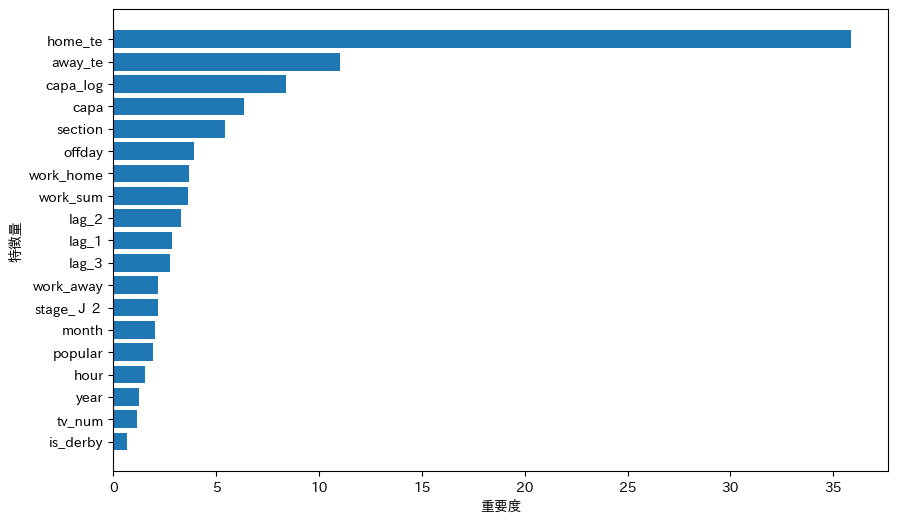

In [165]:
importances = model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_n = 20
top = importance_df.head(top_n)

plt.figure(figsize=(10,6))
plt.barh(top['feature'], top['importance'])
plt.xlabel("重要度")
plt.ylabel("特徴量")
plt.gca().invert_yaxis()
plt.show()

実績値と予測値の分布の確認

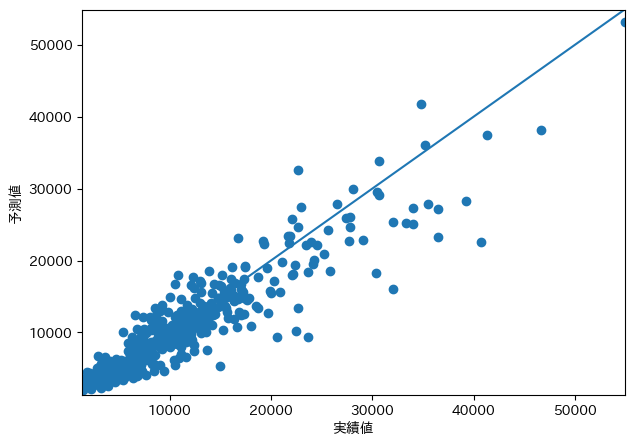

In [166]:
plt.figure(figsize=(7, 5))
plt.scatter(y_valid, y_pred_valid)

min_value = min(y_valid.min(), y_pred_valid.min())
max_value = max(y_valid.max(), y_pred_valid.max())

plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])
plt.plot([min_value,max_value],[min_value,max_value])

plt.xlabel('実績値')
plt.ylabel('予測値')
plt.show()

誤差の多い行と少ない行を抽出し、比較・分析する

In [167]:
pred_df = pd.DataFrame(y_pred_train)
error = pred_df[pred_df > 30000]
normal = pred_df[pred_df < 30000]
error_df = error.dropna()
normal_df = normal.dropna()
print(error_df)
print(normal_df)

                 0
6     31913.592557
24    37240.584675
34    30886.564947
98    36077.421022
119   37520.279139
149   35104.520354
162   33017.066056
190   32763.914808
206   45015.886510
307   38890.753547
363   40212.263659
487   42355.996184
526   36413.568789
581   36426.019706
617   31462.933583
619   46576.600758
627   43935.512804
647   33125.679825
683   34749.257822
717   39140.677878
809   30573.523020
810   33486.264473
862   41568.167145
907   37527.538295
933   43424.646721
937   33755.291947
1001  34302.524521
1022  35220.178580
1030  40767.088674
1073  32338.303769
1085  32029.339618
1104  33077.337365
1134  48884.498784
1160  30579.385082
1195  30629.829368
1226  40728.021465
1301  38425.625710
1358  33065.337522
1362  32737.876738
1370  41280.292010
1386  32169.038435
1402  42358.402303
1405  35371.640909
1418  38278.846816
                 0
0     10660.274491
1      2817.899223
2      5005.889761
3     15316.793227
4      2484.977095
...            ...
1459   3668.

In [168]:
error_idx = error_df.index
error = train.loc[error_idx]

normal_idx = normal_df.index
normal = train.loc[normal_idx]

display(error.describe(), normal.describe())

,capa,capa_log,section,year,month,hour,tv_num,home_te,away_te,lag_1,lag_2,lag_3,work_home,work_away,work_sum,popular,offday,is_derby,stage_Ｊ２
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,29421.068182,10.123691,17.204545,2012.750000,6.181818,16.772727,2.772727,12483.395348,11798.057854,11597.159091,11693.954545,11712.159091,0.443858,0.481508,0.925366,9.326091,0.909091,0.022727,0.454545
std,18219.400169,0.568030,11.866661,0.719334,2.608329,2.055776,0.831464,8204.118995,5513.800002,8620.256563,8402.077691,10133.806624,0.205747,0.267576,0.429038,4.212920,0.362047,0.150756,0.503686
min,10202.000000,9.230437,1.000000,2012.000000,3.000000,13.000000,1.000000,3176.648649,5288.400000,1447.000000,1363.000000,2103.000000,0.147700,0.138036,0.356383,0.000000,0.000000,0.000000,0.000000
25%,15585.750000,9.654176,6.000000,2012.000000,4.000000,15.000000,2.000000,4916.661654,5997.584218,5042.250000,4743.250000,5730.250000,0.280093,0.318413,0.630356,9.675238,1.000000,0.000000,0.000000
50%,20000.000000,9.903538,17.000000,2013.000000,6.000000,17.000000,3.000000,11370.420276,12603.300575,10850.500000,9645.500000,8632.500000,0.397375,0.383609,0.815734,10.995153,1.000000,0.000000,0.000000
75%,43679.000000,10.683209,26.000000,2013.000000,8.250000,19.000000,3.000000,17204.820078,16483.241071,15787.500000,15684.750000,11409.750000,0.565135,0.559813,1.108936,11.468273,1.000000,0.000000,1.000000
max,72327.000000,11.188967,38.000000,2014.000000,11.000000,19.000000,5.000000,37031.384615,20791.740741,40761.000000,34267.000000,40372.000000,0.869417,1.131963,1.976741,13.268396,2.000000,1.000000,1.000000


,capa,capa_log,section,year,month,hour,tv_num,home_te,away_te,lag_1,lag_2,lag_3,work_home,work_away,work_sum,popular,offday,is_derby,stage_Ｊ２
count,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1419.000000,1418.000000,1417.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000
mean,26009.583803,10.043501,19.116901,2012.602817,6.569718,16.383099,2.728873,11163.106456,11148.333022,11183.501762,11150.056417,11147.801694,0.448614,0.496549,0.945163,8.032370,0.930986,0.025352,0.559155
std,14271.944268,0.477409,11.432327,0.616881,2.566398,2.304757,0.724394,7260.295245,5596.338754,8399.671484,8330.551193,8274.518323,0.218563,0.292902,0.457861,4.821134,0.337086,0.157248,0.496663
min,3560.000000,8.177797,1.000000,2012.000000,3.000000,12.000000,1.000000,3176.648649,4959.756757,1104.000000,1104.000000,1104.000000,0.099476,0.101786,0.203559,0.000000,0.000000,0.000000,0.000000
25%,15600.000000,9.655090,9.000000,2012.000000,4.000000,14.000000,2.000000,5282.000000,5997.634146,4991.500000,4984.250000,4930.000000,0.264205,0.292503,0.630346,0.000000,1.000000,0.000000,0.000000
50%,20281.000000,9.917489,18.000000,2013.000000,6.000000,16.000000,3.000000,9969.843750,8711.571429,9265.000000,9265.500000,9277.000000,0.389827,0.388899,0.815504,10.348205,1.000000,0.000000,1.000000
75%,30599.000000,10.328413,29.000000,2013.000000,9.000000,19.000000,3.000000,14775.500000,16716.709677,14036.500000,14033.500000,14150.000000,0.590657,0.627914,1.160913,11.274376,1.000000,0.000000,1.000000
max,72327.000000,11.188967,42.000000,2014.000000,12.000000,20.000000,5.000000,37506.387097,23512.281250,54905.000000,54905.000000,54905.000000,1.664478,2.790233,4.273941,13.546848,2.000000,1.000000,1.000000


# **予測・提出**

In [169]:
predict = model.predict(test)
predict = np.expm1(predict)

submit = pd.read_csv('sample_submit.csv', header=None)

submit[1] = predict
submit.to_csv('submit_1.csv', header=None, index=False)

この時点でのスコアは「3652.3255331196383」

# **改善**

特徴量追加やモデルの再構築、モデルアンサンブルなどを試行する

# **特徴量の追加**

誤差が大きいデータにフラグを立て、重みとして扱う

In [170]:
full_train['error_flag'] = train.index.isin(error_idx).astype(int)
full_test['error_flag'] = test.index.isin(error_idx).astype(int)

# **モデルの再構築**

In [171]:
use_columns = ['capa', 'capa_log', 'section', 'year', 'stage', 'month', 'hour', 'tv_num', 'home_te', 'away_te', 'lag_1', 'lag_2', 'lag_3',
               'work_home', 'work_away', 'work_sum', 'popular', 'offday', 'is_derby', 'error_flag']
y = full_train['y']
train = full_train[use_columns]
test = full_test[use_columns]

In [172]:
train = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

test = test.reindex(columns=train.columns, fill_value=0)

X_train, X_valid, y_train, y_valid = train_test_split(train, y, random_state = 82)

y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

In [173]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(y_train_log.shape)
print(y_valid_log.shape)

(1464, 19)
(1464,)
(488, 19)
(488,)
(1464,)
(488,)


In [174]:
model2 = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=100,
    early_stopping_rounds=50
)

weights = (
    X_train['capa'] / X_train['capa'].max() +
    X_train['home_te'] / X_train['home_te'].max() +
    X_train['away_te'] / X_train['away_te'].max()
)

weights = weights * 1000


model2.fit(
    X_train, y_train_log,
    eval_set=(X_valid, y_valid_log),
    sample_weight=weights
)

0:	learn: 0.7463741	test: 0.7438793	best: 0.7438793 (0)	total: 20.5ms	remaining: 41s
100:	learn: 0.3016288	test: 0.3618604	best: 0.3618604 (100)	total: 1.15s	remaining: 21.6s
200:	learn: 0.2564477	test: 0.3285671	best: 0.3285671 (200)	total: 2.19s	remaining: 19.6s
300:	learn: 0.2109290	test: 0.3018498	best: 0.3018498 (300)	total: 3.23s	remaining: 18.3s
400:	learn: 0.1846005	test: 0.2957495	best: 0.2956470 (398)	total: 4.58s	remaining: 18.3s
500:	learn: 0.1649107	test: 0.2940392	best: 0.2940392 (500)	total: 5.83s	remaining: 17.4s
600:	learn: 0.1484985	test: 0.2935152	best: 0.2934862 (553)	total: 7.19s	remaining: 16.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2934862431
bestIteration = 553

Shrink model to first 554 iterations.


In [175]:
y_pred_train = model2.predict(X_train)
y_pred_train = np.exp(y_pred_train)

rmse_train = np.sqrt(MSE(y_train, y_pred_train))

y_pred_valid = model2.predict(X_valid)
y_pred_valid = np.exp(y_pred_valid)
rmse_valid = np.sqrt(MSE(y_valid, y_pred_valid))

print('学習データ', rmse_train)
print('評価データ', rmse_valid)

学習データ 1703.0334766151248
評価データ 3264.4599668359538


In [176]:
predict = model2.predict(test)
predict = np.expm1(predict)

submit = pd.read_csv('sample_submit.csv', header=None)

submit[1] = predict
submit.to_csv('submit_2.csv', header=None, index=False)

# **結果**

スコア:4105.999384592293

submit_1のモデルの方が評価は高かったので、そちらを採用

順位としてはだいたい1000/4000となった

# **考察**

error_flagはK-Foldを行っていないため、もしかしたらリークの可能性があるのかもしれない。

sanmple_weightは調べたところRMSE自体に重みをつける意味はないらしく、Weight RMSEという評価方法があるらしいので、コンペでは使えないが知見として得ることができた。